<a href="https://colab.research.google.com/github/armenmatoosian/huggingface_open_source_ai_cookbook/blob/main/agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build an agent with tool-calling superpowers 🦸 using smolagents
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

This notebook demonstrates how you can use [**smolagents**](https://huggingface.co/docs/smolagents/index) to build awesome **agents**!

What are **agents**? Agents are systems that are powered by an LLM and enable the LLM (with careful prompting and output parsing) to use specific *tools* to solve problems.

These *tools* are basically functions that the LLM couldn't perform well by itself: for instance for a text-generation LLM like [Llama-3-70B](https://huggingface.co/meta-llama/Meta-Llama-3-70B-Instruct), this could be an image generation tool, a web search tool, a calculator...

What is **smolagents**? It's an library that provides building blocks to build your own agents! Learn more about it in the [documentation](https://huggingface.co/docs/smolagents/index).

Let's see how to use it, and which use cases it can solve.

Run the line below to install required dependencies:

In [1]:
!pip install smolagents datasets langchain sentence-transformers faiss-cpu duckduckgo-search openai langchain-community --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Let's login in order to call the HF Inference API:

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## 1. 🏞️ Multimodal + 🌐 Web-browsing assistant

For this use case, we want to show an agent that browses the web and is able to generate images.

To build it, we simply need to have two tools ready: image generation and web search.
- For image generation, we load a tool from the Hub that uses the HF Inference API (Serverless) to generate images using Stable Diffusion.
- For the web search, we use a built-in tool.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tool.py:   0%|          | 0.00/635 [00:00<?, ?B/s]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Generate me a photo of the car that James bond drove in the latest movie.                                       │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  query = "latest James Bond movie and the car driven"                                                             
  latest_movie_car = web_search(query=query)                                                                       
  print(latest_movie_car)                                                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
## Search Results

[No Time To Die: The cars of the new James Bond film - 
Driving.co.uk](https://www.driving.co.uk/news/diversions/no-time-die-cars-james-bond-film/)
NO TIME TO DIE, the 25th film in the James Bond franchise, and the final one starring Daniel Craig as 007, has 
arrived after long delays due to the coronavirus pandemic.. Here we profile the cars from Aston Martin, Land Rover,
Maserati and Toyota that appear in the spotlight. 1. Aston Martin DB5. It's arguably the most famous film car of 
all time, and Bond's silver Aston Martin DB5 is back ...

[James Bond: Every Car Appearing In No Time To Die - Screen 
Rant](https://screenrant.com/james-bond-no-time-die-movie-cars/)
The No Time To Die trailer includes a brief glimpse of Bond whipping a sheet off what appears to be the Aston 
Martin V8 Vantage, as driven by Timothy Dalton in The Living Daylights.The Aston Martin website actually only lists
the V8 Saloon, similar to the Dalton-era model in many aspects. Nevertheless, the number plates are the same, 
implying that the Craig's V8 is intended to be the car from ...

[Every Car James Bond Drives in 'No Time To Die' - 
MotorBiscuit.com](https://www.motorbiscuit.com/every-car-james-bond-drives-no-time-to-die/)
James Bond: Agent 007. He loves action, he loves gadgets, and he loves classic cars. The upcoming film features 
James Bond behind the wheel of a myriad of breathtaking classic cars-including two Aston Martins. The BMW-powered 
DB5 stunt car may be the most unique custom car in a film since the new batmobile.

[These are All the Cars in the New James Bond Movie 'No ... - 
GTPlanet](https://www.gtplanet.net/these-are-all-the-cars-in-the-new-james-bond-movie-no-time-to-die/)
Immediately, the trailer kicks off with Bond behind the wheel of the 1964 Aston Martin DB5 — voted GTPlanet's best 
car in movie history.The Aston lets loose with a mighty powerslide, showing off battle scars along its right side —
at least some of which comes from a collision with a classic Range Rover.

[No Time To Die: nine cars (and one bike) from the new James Bond 
movie](https://www.topgear.com/car-news/movies/no-time-die-nine-cars-and-one-bike-new-james-bond-movie)
The new James Bond spectacle entitled No Time To Die features something called a 'DB5'.Apparently, it was a car a 
British company that goes by the name 'Aston Martin' was building back in ...

[All of the Bond cars of 'No Time To Die' (caution for 
spoilers)](https://www.autoblog.com/features/no-time-to-die-james-bond-cars)
In short, though, the cars of Daniel Craig's last Bond film don't disappoint, and neither do the stunts. There is 
plenty for car enthusiasts to ogle at when No Time To Die opens in theaters on ...

[Here are all the cars Bond will drive (and wreck) in No Time To 
Die](https://www.thegentlemansjournal.com/article/here-are-all-the-cars-bond-will-drive-and-wreck-in-no-time-to-die
/)
What is it? Coincidentally, the Series III — Land Rover's iconic 1971 workhorse — also last appeared in The Living 
Daylights. 007's latest model is blue, and has both a spare wheel on the bonnet and custom wheel arches.. When will
we see it? In Jamaica, when Bond is wallowing deep in sun-soaked retirement.The car looks to be his daily runaround
before he is pulled back into the spy ...

[The cars and chase scenes of "No Time To Die" - Motor 
Authority](https://www.motorauthority.com/news/1133801_the-cars-and-chase-scenes-of-no-time-to-die)
Kirk Bell October 9, 2021 Comment Now! A new James Bond film, "No Time To Die," is hitting the theaters, and for 
car guys that means cool cars become the stars as much as the glitzy Hollywood ...

[Aston Martin Cars Featured in James Bond Film, No Time to 
Die](https://www.astonmartinpalmbeach.com/james-bond-aston-martin-no-time-to-die/)
James Bond DB5 Car Chase Scene Highlights in No Time to Die. 10 Aston Martin DB5s were used in No Time to Die—2 
actual models and 8 replicas.The replicas of these classic 60s Aston Martin 

[Step 1: Duration 4.21 seconds| Input tokens: 2,165 | Output tokens: 62]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  image = image_generator(prompt="Aston Martin DB5 from No Time To Die, high-res, photorealistic")                 
  final_answer(image)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x7B8069585A50>

[Step 2: Duration 40.68 seconds| Input tokens: 5,616 | Output tokens: 146]

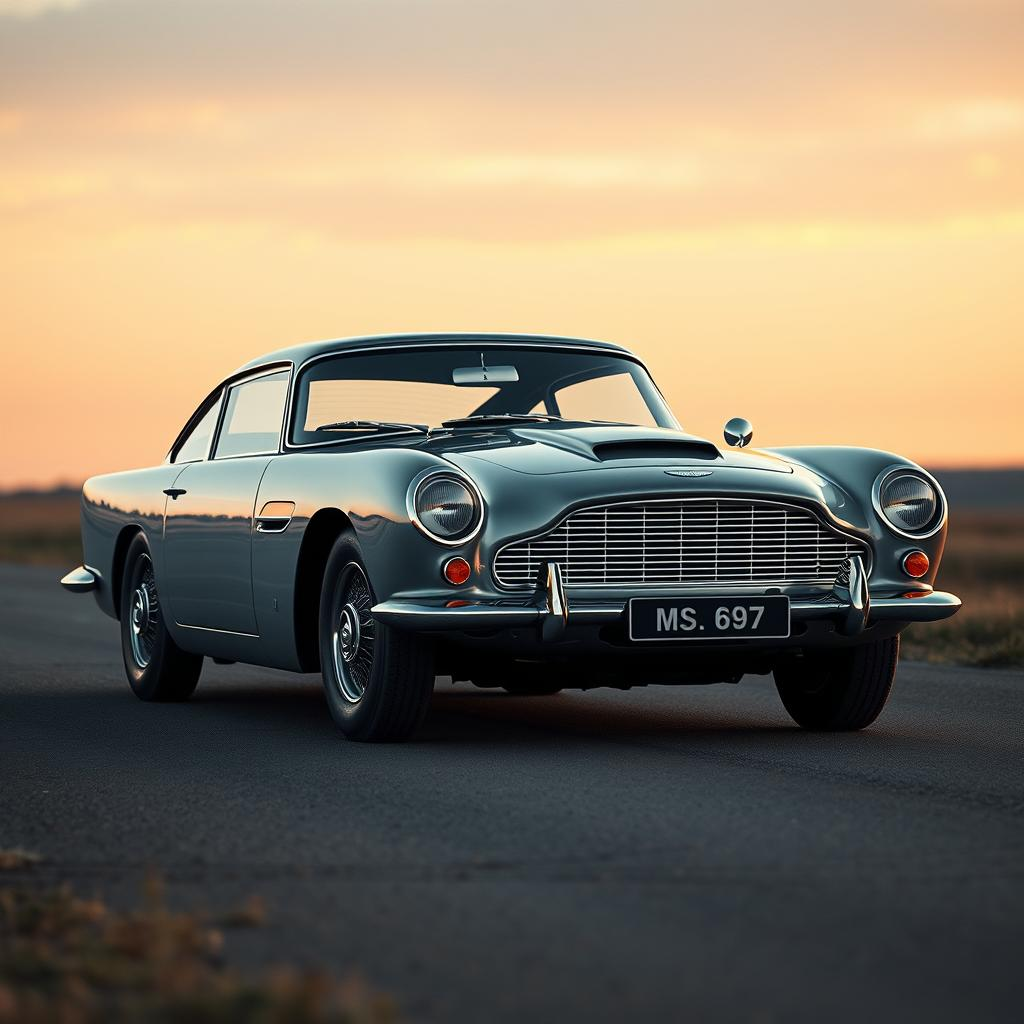

In [3]:
from smolagents import load_tool, CodeAgent, HfApiModel, DuckDuckGoSearchTool

# Import tool from Hub
image_generation_tool = load_tool("m-ric/text-to-image", trust_remote_code=True)


search_tool = DuckDuckGoSearchTool()

model = HfApiModel("Qwen/Qwen2.5-72B-Instruct")
# Initialize the agent with both tools
agent = CodeAgent(
    tools=[image_generation_tool, search_tool], model=model
)

# Run it!
result = agent.run(
    "Generate me a photo of the car that James bond drove in the latest movie.",
)
result

![Image of an Aston Martin DB5](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/agents_db5.png)

## 2. 📚💬 RAG with Iterative query refinement & Source selection

Quick definition: Retrieval-Augmented-Generation (RAG) is ___“using an LLM to answer a user query, but basing the answer on information retrieved from a knowledge base”.___

This method has many advantages over using a vanilla or fine-tuned LLM: to name a few, it allows to ground the answer on true facts and reduce confabulations, it allows to provide the LLM with domain-specific knowledge, and it allows fine-grained control of access to information from the knowledge base.

- Now let’s say we want to perform RAG, but with the additional constraint that some parameters must be dynamically generated. For example, depending on the user query we could want to restrict the search to specific subsets of the knowledge base, or we could want to adjust the number of documents retrieved. The difficulty is: **how to dynamically adjust these parameters based on the user query?**

- A frequent failure case of RAG is when the retrieval based on the user query does not return any relevant supporting documents. **Is there a way to iterate by re-calling the retriever with a modified query in case the previous results were not relevant?**


🔧 Well, we can solve the points above in a simple way: we will **give our agent control over the retriever's parameters!**

➡️ Let's show how to do this. We first load a knowledge base on which we want to perform RAG: this dataset is a compilation of the documentation pages for many `huggingface` packages, stored as markdown.


In [4]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

Now we prepare the knowledge base by processing the dataset and storing it into a vector database to be used by the retriever. We are going to use LangChain, since it features excellent utilities for vector databases:


In [5]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

docs_processed = RecursiveCharacterTextSplitter(chunk_size=500).split_documents(
    source_docs
)[:1000]

embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
vectordb = FAISS.from_documents(documents=docs_processed, embedding=embedding_model)

<ipython-input-5-b8636c30f857>:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now that we have the database ready, let’s build a RAG system that answers user queries based on it!

We want our system to select only from the most relevant sources of information, depending on the query.

Our documentation pages come from the following sources:

In [13]:
all_sources = list(set([doc.metadata["source"] for doc in docs_processed]))
print(all_sources)

['datasets', 'peft', 'evaluate', 'diffusers', 'pytorch-image-models', 'hf-endpoints-documentation', 'transformers', 'optimum', 'hub-docs', 'blog', 'datasets-server', 'deep-rl-class', 'gradio', 'course']


👉 Now let's build a `RetrieverTool` that our agent can leverage to retrieve information from the knowledge base.

Since we need to add a vectordb as an attribute of the tool, we cannot simply use the [simple tool constructor](https://huggingface.co/docs/transformers/main/en/agents#create-a-new-tool) with a `@tool` decorator: so we will follow the advanced setup highlighted in the [advanced agents documentation](https://huggingface.co/docs/transformers/main/en/agents_advanced#directly-define-a-tool-by-subclassing-tool-and-share-it-to-the-hub).

In [18]:
import json
from smolagents import Tool
from langchain_core.vectorstores import VectorStore


class RetrieverTool(Tool):
    name = "retriever"
    description = "Retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        },
        "source": {"type": "string",
                   "description": "",
                   "nullable": True  # Add nullable: True to the source input
        },
        "number_of_documents": {
            "type": "string",
            "description": "the number of documents to retrieve. Stay under 10 to avoid drowning in docs",
            "nullable": True  # Add nullable: True to the source input
        },
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, all_sources: str, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb
        self.inputs["source"]["description"] = (
            f"The source of the documents to search, as a str representation of a list. Possible values in the list are: {all_sources}. If this argument is not provided, all sources will be searched.".replace(
                "'", "`"
            )
        )

    def forward(self, query: str, source: str = None, number_of_documents=7) -> str:
        assert isinstance(query, str), "Your search query must be a string"
        number_of_documents = int(number_of_documents)

        if source:
            if isinstance(source, str) and "[" not in str(
                source
            ):  # if the source is not representing a list
                source = [source]
            source = json.loads(str(source).replace("'", '"'))

        docs = self.vectordb.similarity_search(
            query,
            filter=({"source": source} if source else None),
            k=number_of_documents,
        )

        if len(docs) == 0:
            return "No documents found with this filtering. Try removing the source filter."
        return "Retrieved documents:\n\n" + "\n===Document===\n".join(
            [doc.page_content for doc in docs]
        )

### Optional: Share your Retriever tool to Hub

To share your tool to the Hub, first copy-paste the code in the RetrieverTool definition cell to a new file named for instance `retriever.py`.

When the tool is loaded from a separate file, you can then push it to the Hub using the code below (make sure to login with a `write` access token)

In [11]:
share_to_hub = True

if share_to_hub:
    from huggingface_hub import login
    from retriever import RetrieverTool

    login("your_token")

    tool = RetrieverTool(vectordb, all_sources)

    tool.push_to_hub(repo_id="m-ric/retriever-tool")

    # Loading the tool
    from smolagents import load_tool

    retriever_tool = load_tool(
        "m-ric/retriever-tool", vectordb=vectordb, all_sources=all_sources
    )

ModuleNotFoundError: No module named 'retriever'

### Run the agent!

In [20]:
from smolagents import HfApiModel, ToolCallingAgent

model = HfApiModel("Qwen/Qwen2.5-72B-Instruct")

retriever_tool = RetrieverTool(vectordb=vectordb, all_sources=all_sources)
agent = ToolCallingAgent(tools=[retriever_tool], model=model)
#doesn't support verbose argument according to Gemini, ORIGINAL CODE: agent = ToolCallingAgent(tools=[retriever_tool], model=model, verbose=0)

agent_output = agent.run("Please show me a LORA finetuning script")

print("Final output:")
print(agent_output)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Please show me a LORA finetuning script                                                                         │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'retriever' with arguments: {'number_of_documents': '3', 'query': 'LORA finetuning script'}       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: Retrieved documents:

|LoRA (Low-Rank Adaptation of Large Language Models)](https://hf.co/papers/2106.09685) is a popular and lightweight
training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller 
number of new weights into the model and only these are trained. This makes training with LoRA much faster, 
memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share. LoRA
can also be combined with other training
===Document===
As with the script parameters, a walkthrough of the training script is provided in the 
|Text-to-image](text2image#training-script) training guide. Instead, this guide takes a look at the LoRA relevant 
parts of the script.
===Document===
<Tip>

The following sections highlight parts of the training script that are important for understanding how to modify 
it, but it doesn't cover every aspect of the script in detail. If you're interested in learning more, feel free to 
read through the 
|script](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/text_to_image_lora.py) and let 
us know if you have any questions or concerns.

</Tip>

## Script parameters

[Step 1: Duration 5.69 seconds| Input tokens: 1,492 | Output tokens: 25]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': 'To create a LORA finetuning script, you may refer to   │
│ this [example script for                                                                                        │
│ text_to_image_lora.py](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/text_to_image_ │
│ lora.py). For a deeper understanding of how LORA works, read the [LoRA                                          │
│ paper](https://hf.co/papers/2106.09685).'}                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: To create a LORA finetuning script, you may refer to this [example script for 
text_to_image_lora.py](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/text_to_image_lora
.py). For a deeper understanding of how LORA works, read the [LoRA paper](https://hf.co/papers/2106.09685).

[Step 2: Duration 10.50 seconds| Input tokens: 3,314 | Output tokens: 125]

Final output:
To create a LORA finetuning script, you may refer to this [example script for text_to_image_lora.py](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/text_to_image_lora.py). For a deeper understanding of how LORA works, read the [LoRA paper](https://hf.co/papers/2106.09685).


What happened here? First, the agent launched the retriever with specific sources in mind (`['transformers', 'blog']`).

But this retrieval did not yield enough results ⇒ no problem! The agent could iterate on previous results, so it just re-ran its retrieval with less restrictive search parameters.
Thus the research was successful!

Note that **using an LLM agent** that calls a retriever as a tool and can dynamically modify the query and other retrieval parameters **is a more general formulation of RAG**, which also covers many RAG improvement techniques like iterative query refinement.

## 3. 💻 Debug Python code
Since the CodeAgent has a built-in Python code interpreter, we can use it to debug our faulty Python script!

In [21]:
from smolagents import CodeAgent

agent = CodeAgent(tools=[], model=HfApiModel("Qwen/Qwen2.5-72B-Instruct"))

code = """
numbers=[0, 1, 2]

for i in range(4):
    print(numbers(i))
"""

final_answer = agent.run(
    "I have some code that creates a bug: please debug it, then run it to make sure it works and return the final code",
    additional_args=dict(code=code)
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I have some code that creates a bug: please debug it, then run it to make sure it works and return the final    │
│ code                                                                                                            │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'code': '\nnumbers=[0, 1, 2\]\n\nfor i in range(4):\n    print(numbers(i))\n'}.                                │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  numbers = [0, 1, 2]                                                                                              
                                                                                                                   
  # Fix 1: Change the range to the length of the numbers list                                                      
  for i in range(len(numbers)):                                                                                    
      # Fix 2: Access the list element using square brackets                                                       
      print(numbers[i])                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
0
1
2

Out: None

[Step 1: Duration 8.75 seconds| Input tokens: 2,093 | Output tokens: 234]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(numbers = [0, 1, 2]                                                                                 
                                                                                                                   
  # Fix 1: Change the range to the length of the numbers list                                                      
  for i in range(len(numbers)):                                                                                    
      # Fix 2: Access the list element using square brackets                                                       
      print(numbers[i])                                                                                            
  )                                                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
0
1
2

Code parsing failed on line 1 due to: SyntaxError
final_answer(numbers = [0, 1, 2\]              ^
Error: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<unknown>, line 1)

[Step 2: Duration 4.62 seconds| Input tokens: 4,548 | Output tokens: 338]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  debugged_code = '''numbers = [0, 1, 2]                                                                           
                                                                                                                   
  # Fix 1: Change the range to the length of the numbers list                                                      
  for i in range(len(numbers)):                                                                                    
      # Fix 2: Access the list element using square brackets                                                       
      print(numbers[i])                                                                                            
  '''                                                                                                              
  final_answer(debugged_code)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: numbers = [0, 1, 2]

# Fix 1: Change the range to the length of the numbers list
for i in range(len(numbers)):
    # Fix 2: Access the list element using square brackets
    print(numbers[i])

[Step 3: Duration 5.93 seconds| Input tokens: 7,321 | Output tokens: 496]

As you can see, the agent tried the given code, gets an error, analyses the error, corrects the code and returns it after veryfing that it works!

And the final code is the corrected code:

In [22]:
print(final_answer)

numbers = [0, 1, 2]

# Fix 1: Change the range to the length of the numbers list
for i in range(len(numbers)):
    # Fix 2: Access the list element using square brackets
    print(numbers[i])



## ➡️ Conclusion

The use cases above should give you a glimpse into the possibilities of our Agents framework!

For more advanced usage, read the [documentation](https://huggingface.co/docs/smolagents/index).

All feedback is welcome, it will help us improve the framework! 🚀